In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from glob import glob


from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
TRAIN_DATASET = sorted([x for x in Path("./data/HAI 2.0/training").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./data/HAI 2.0/testing").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("./data/HAI 2.0/validation").glob("*.csv")])

In [ ]:
TRAIN_DATASET

[PosixPath('data/HAI 2.0/training/train1.csv'),
 PosixPath('data/HAI 2.0/training/train2.csv'),
 PosixPath('data/HAI 2.0/training/train3.csv')]

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target, engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [6]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.head()

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547


train dataset에는 attack 필드가 없다. 비지도 학습을 할 것이기 때문에 당연한거고 가공할 필드 중 time은 하지 않음로 drop 해준다.

In [8]:
TIMESTAMP_FIELD = 'time'
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = 'attack'
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

### 데이터 정규화

In [9]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
def normalize(df):
  normalized_df = df.copy()
  for c in df.columns:
    if TAG_MIN[c] == TAG_MAX[c]:
      normalized_df[c] = df[c] - TAG_MIN[c]
    else:
      normalized_df[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
  return normalized_df

In [11]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [12]:
TRAIN_DF.head()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,...,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.0,0.567254
1,0.378459,0.0,0.0,0.226548,0.351630,0.000154,0.400309,0.359799,0.795139,0.543787,...,0.592759,0.0,0.326835,0.254278,0.337838,0.916661,0.266530,0.250469,1.0,0.506623
2,0.378459,0.0,0.0,0.226810,0.314829,0.000154,0.392647,0.461334,0.804977,0.538611,...,0.595906,0.0,0.326338,0.255413,0.337838,0.916661,0.265099,0.255028,1.0,0.464946
3,0.378953,0.0,0.0,0.226810,0.229915,0.000154,0.393743,0.309032,0.814815,0.450733,...,0.596221,0.0,0.326338,0.257590,0.331076,0.916661,0.264281,0.252816,1.0,0.443695
4,0.380435,0.0,0.0,0.226810,0.157685,0.000154,0.414918,0.690968,0.824074,0.319543,...,0.599053,0.0,0.326835,0.256196,0.337838,0.916661,0.262577,0.247117,1.0,0.480956


### 학습 모델 선정

keras 사용하여 autoencoder 구현  
또한 autoencoder의 레이어를 LSTM으로 구성하면 시퀀스 학습이 가능

In [13]:
def temporalize(X, y, timesteps):
  output_X = []
  output_y = []
  for i in range(len(X) - timesteps - 1):
    t = []
    for j in range(1, timesteps + 1):
      t.append(X[[i+j+1], :])
    output_X.append(t)
    output_y.append(y[i + timesteps + 1])
  return np.squeeze(np.array(output_X)), np.array(output_y)

시계열 데이터의 특징 추출은 1D Convolution이 적절하다.  
CNN에서는 2D Convolution을 사용하는데 필터를 이동시킬 축을 하나로만 제한하여 시퀀스 처리를 용이하게 한다.

In [14]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(921603, 1, 79)

### 학습 모델의 구조

#### Conv1D  
- filters : convolution 연산의 output 출력 수
- kernel_size : timestamp를 얼마만큼 묶어서 볼 것인가 (=window_size)
- paddning : 한 쪽 방향으로 얼마마늠 padding 할 것 인가
- dilation: kernel 내부에서 얼마만큼의 간격으로 kernel을 적용할 것인가
- strider: convolution layer의 이동크기

#### LSTM  
- unit : 출력 차원층만 설정

#### 모델의 구조
Conv1D - Dense - LSTM - Dense  
encoder와 decoder의 대칭이 되도록 설계  
LSTM의 입력으로는 3차원 데이터가 필요하기 때문에 reshape로 3차원으로 만들어줌

In [15]:
def conv_model(x):
  n_steps = x.shape[1]
  n_features = x.shape[2]
  
  keras.backend.clear_session()
  
  model = keras.Sequential(
    [
      layers.Input(shape=(n_steps, n_features)),
      layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last', dilation_rate=1, activation='linear'),
      layers.Dense(128),
      layers.LSTM(units=64, activation="relu",name="lstm_1", return_sequences=False), # LSTM과 다른점 1 (return_sequences)
      layers.Dense(64),
      layers.RepeatVector(n_steps), # LSTM 코드와 다른 점 2 (repearvector)
      layers.Dense(64),
      layers.LSTM(units=64, activation='relu', name="lstm_2", return_sequences=True),
      layers.Dense(128),
      layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last', dilation_rate=1, activation="linear"),
      layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
    ]
  )
  return model

### 모델 구조 확인

In [16]:
model = conv_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

2022-04-12 14:24:49.887332: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 14:24:50.515700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30970 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 512)            2589184   
_________________________________________________________________
dense (Dense)                (None, 1, 128)            65664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             3

## 모델 학습하기

In [17]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

epochs = 5
batch = 64

history = model.fit(x_train, x_train,
                    epochs=epochs, batch_size=batch,
                    validation_split=0.2, callbacks=callbacks).history

model.save('HAI_Autoencoder_LSTM.h5')

2022-04-12 14:24:55.648177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-12 14:24:57.945618: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


11521/11521 [==============================] - 145s 12ms/step - loss: 0.0019 - val_loss: 6.6069e-04
Epoch 2/5
11521/11521 [==============================] - 138s 12ms/step - loss: 1.5160e-04 - val_loss: 6.9724e-04
Epoch 3/5
11521/11521 [==============================] - 138s 12ms/step - loss: 9.7784e-05 - val_loss: 6.6760e-04
Epoch 4/5
11521/11521 [==============================] - 136s 12ms/step - loss: 6.6722e-05 - val_loss: 3.3905e-04
Epoch 5/5
11521/11521 [==============================] - 138s 12ms/step - loss: 5.6013e-05 - val_loss: 6.9177e-04


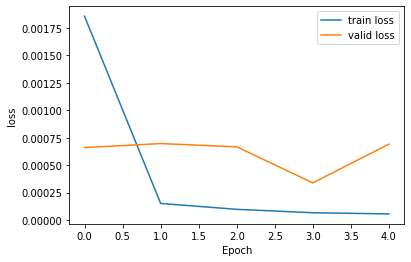

In [18]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [19]:
model = load_model('best_model.h5')

### 검증 데이터셋에 적용하여 Anomaly Detection

In [20]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.to_csv('VALIDATION_DF_RAW.csv')
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [21]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

<AxesSubplot:>

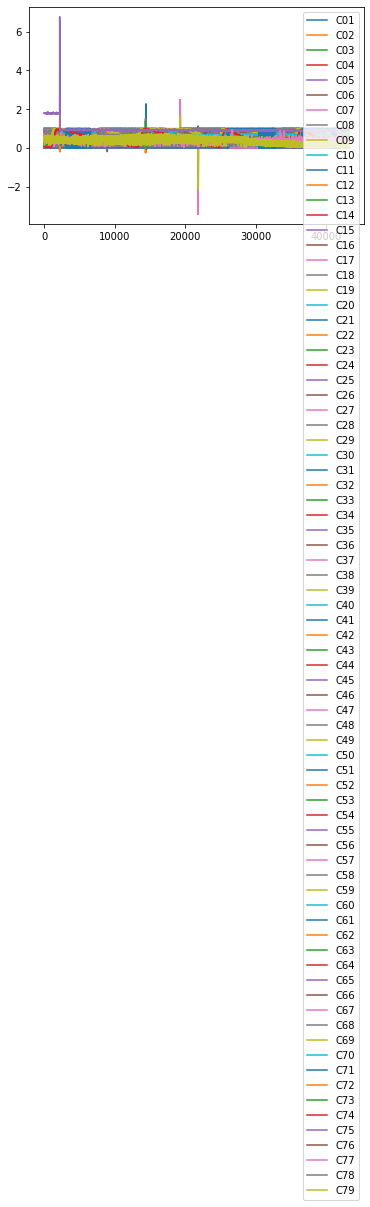

In [22]:
VALIDATION_DF.plot()

<AxesSubplot:>

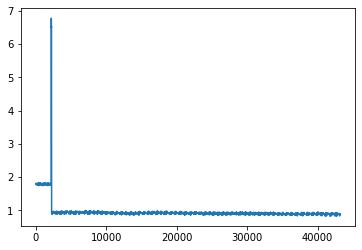

In [23]:
VALIDATION_DF['C75'].plot()

위와 같은 reconstructor error가 높은 구간 발생시 정상범위에 맞게 임의로 조절하여야 함  
이 데이터셋의 경우 label값이 존재했기 때문에 이와 같은 전처리가 가능

In [24]:
VALIDATION_DF['C75'][:2110] = 0.95

In [26]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(43201, 1, 79)

모델의 결과가 3차원의 형태이기 떄문에 복원된 결과와의 차이를 확인하기 위해 2차원으로 다시 바꿔줘야한다. -> flatten 함수를 구현하여 활용

In [27]:
def flatten(X):
  flattened_X = np.empty((X.shape[0], X.shape[2]))
  for i in range(X.shape[0]):
    flattened_X[i] = X[i, (X.shape[1]-1), :]
  return(flattened_X)

def scale(X, scaler):
  for i in range(X.shape[0]):
    X[i, :, :] = scaler.transform(X[i, :, :])

모델에 의해 재구성된 값을 실제 값과 차이를 구해 재구성 손실(reconstruction error)값을 구해준다.  
정상인 경우 모델이 잘 학습되어 복원이 잘되어 recontruction error 값이 작게 나오고  
공격인 경우 정규화된 값에서 0과 1을 벗어나기 떄문에 reconstruction error 값이 크게 나올 것이다.

In [28]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(valid_mse)
print(time.time() - start)

(43201, 1, 79)
(43201, 79)
(43201,)
[0.00012695 0.00015061 0.00015519 ... 0.00024124 0.00024806 0.00028714]
4.803983449935913


### precision Recall Curve

threshold의 경우 Recall Precision의 값이 교차되는 지점을 기준으로 조금씩 수정하면서 결과 확인

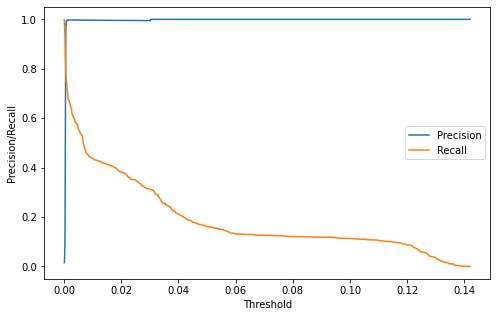

In [29]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 
                         'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [30]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.8203497615262321 , recall:  0.8203497615262321
threshold:  0.0004906611596828335


Text(0.5, 0, 'Data point index')

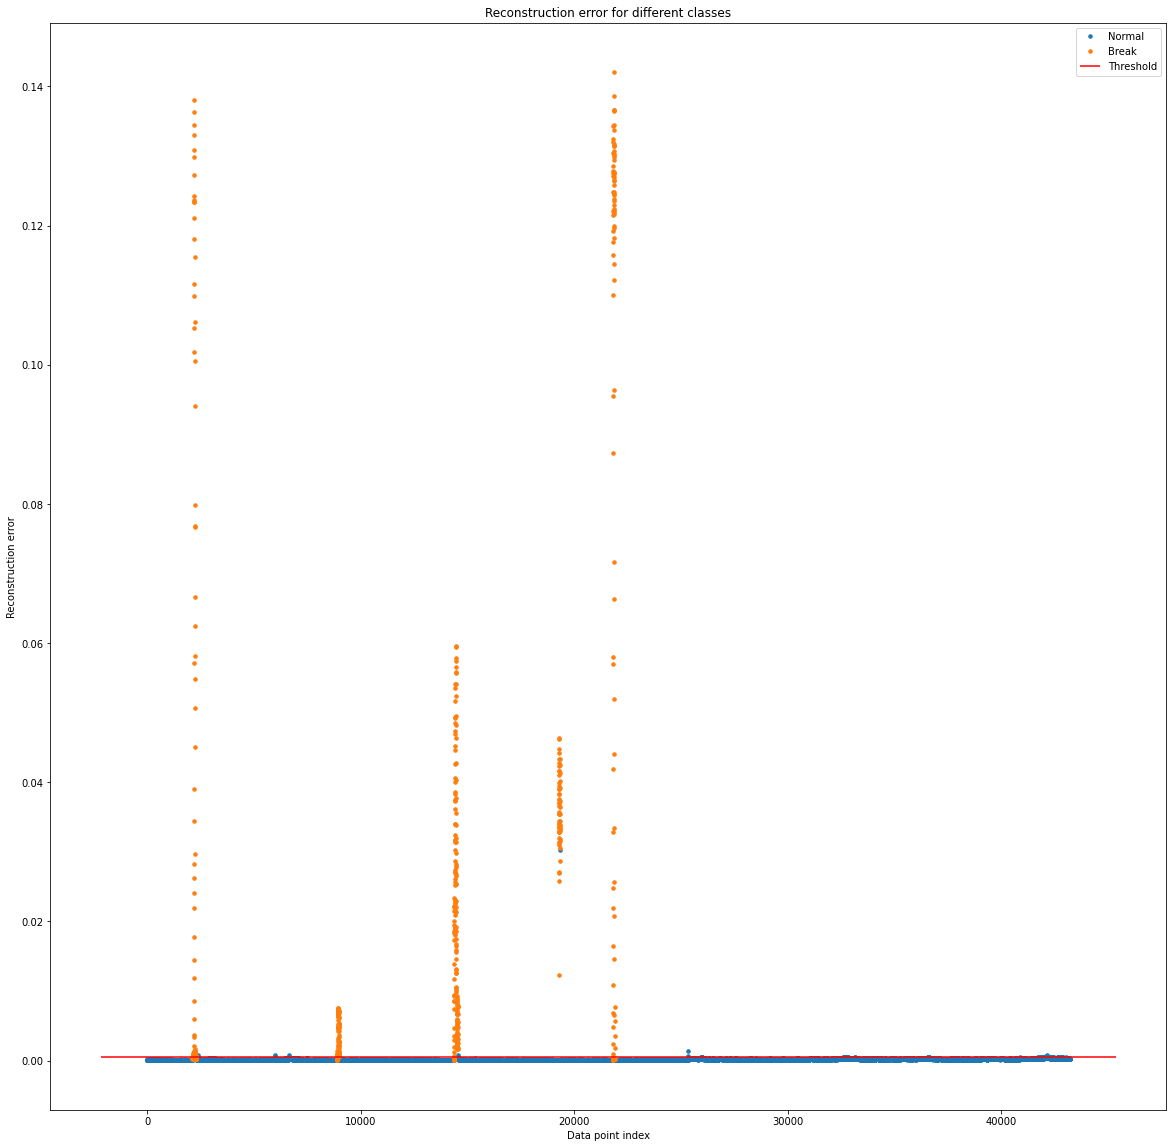

In [31]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse ,
                         'True_class': list(VALIDATION_DF_RAW['attack'])})
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")